In [7]:
# Import necessary libraries for loading the dataset
import torch
from torchvision import datasets, transforms
from custom_labels import label_mapping, apply_custom_labels

# Load the fashion MNIST dataset with custom labels

In [8]:
%%time

data_path = '../data'

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root=data_path, train=True, transform=transform, download=True)
train_dataset.targets = apply_custom_labels(train_dataset.targets)

test_dataset = datasets.FashionMNIST(root=data_path, train=False, transform=transform, download=True)
test_dataset.targets = apply_custom_labels(test_dataset.targets)

CPU times: user 2.18 s, sys: 244 ms, total: 2.42 s
Wall time: 1.54 s


# Deep Learning Experimentation and Evaluation

In [9]:
# import libraries needed for the DL experiments and evaluation
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import os

In [10]:
%%time

batch_size = 64

# taking 20% of train as validation
valid_size = int(0.2 * len(train_dataset)) 
train_size = len(train_dataset) - valid_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CPU times: user 8.88 ms, sys: 3 ms, total: 11.9 ms
Wall time: 5.47 ms


In [11]:
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, save_dir=None):
    """
    Train the model and save the best checkpoint.
    Parameters:
        model: Model to train
        train_loader: Training data loader
        valid_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Number of epochs
        save_dir: Directory to save the best checkpoint and loss curves
    """
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')

    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculating average training loss for this epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        # Calculating average validation loss for this epoch
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')

        # save model checkpoint
        if save_dir and valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            checkpoint_path = os.path.join(save_dir, f'best_checkpoint.pth')
            print(f"Saving best checkpoint to {checkpoint_path}")
            torch.save(model.state_dict(), checkpoint_path)


    # Plot training and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)

    if save_dir:
        curve_path = os.path.join(save_dir, 'loss_curves.png')
        plt.savefig(curve_path)
    else:
        plt.show()


In [12]:
def evaluate(model, test_loader, num_classes):
    """
    Evaluate the model on the test set
    Parameter:
        model: Model to be evaluated
        test_loader: Test set loader
        num_classes: Number of classes
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    confusion = confusion_matrix(y_true, y_pred)

    class_report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('\nConfusion Matrix:')
    print(confusion)
    print('\nClassification Report:')
    print(class_report)


## Single CNN model

In [13]:
class SingleCNN(nn.Module):
    def __init__(self):
        super(SingleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(in_features=32 * 12 * 12, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=len(label_mapping))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 32 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1/10, Train Loss: 0.1397, Valid Loss: 0.0919
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.0829, Valid Loss: 0.0800
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0659, Valid Loss: 0.0643
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.0549, Valid Loss: 0.0664
Epoch 5/10, Train Loss: 0.0463, Valid Loss: 0.0608
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0390, Valid Loss: 0.0605
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 7/10, Train Loss: 0.0331, Valid Loss: 0.0589
Saving best checkpoint to ./outputs/single_cnn/best_checkpoint.pth
Epoch 8/10, Train Loss: 0.0282, Valid Loss: 0.0627
Epoch 9/10, Train Loss: 0.0242, Valid Loss: 0.0625
Epoch 10/10, Train Loss: 0.0218, Valid Loss: 0.0625
CPU times: user 8min 32s, sys: 7min 21s, total: 15min 54s
Wall time: 2min 9s


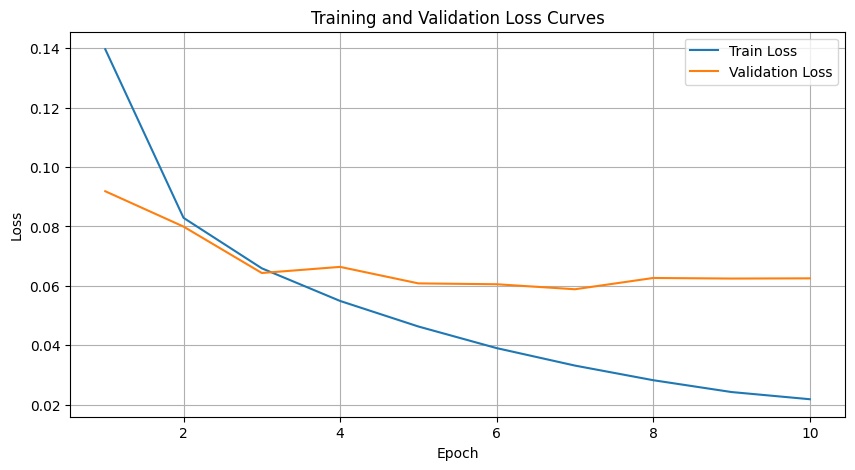

In [14]:
%%time

# Initialize the model
single_cnn = SingleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(single_cnn.parameters(), lr=0.001)

train(single_cnn, train_loader, valid_loader, criterion, optimizer, num_epochs=10,save_dir='./outputs/single_cnn')


In [15]:
%%time

# Evaluate the single cnn model
evaluate(single_cnn, test_loader, num_classes=5)

Accuracy: 97.89%
F1 Score: 0.9788
Precision: 0.9788
Recall: 0.9789

Confusion Matrix:
[[3926    4   53    1   16]
 [  12  981    7    0    0]
 [  97    2  898    0    3]
 [   1    0    0 2999    0]
 [   8    1    1    5  985]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98      4000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.94      0.90      0.92      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.98      0.98      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 5.1 s, sys: 5.17 s, total: 10.3 s
Wall time: 1.44 s


### Data Augumentation 

Data Augumentation can be used to treat class imbalance problem, however in this particular case before moving towards class imbalance problem, lets proceed to help the model at hand to generalize, above loss curves showcase that model is overfitting in very early stage of the training (epoch 2). Lets augument the data to try to combat this issue.

In [16]:
%%time

data_path = '../data'

# performig some transformations to the data for data augumentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])

train_dataset_aug = datasets.FashionMNIST(root=data_path, train=True, transform=transform, download=True)
train_dataset_aug.targets = apply_custom_labels(train_dataset_aug.targets)

valid_size_aug = int(0.2 * len(train_dataset_aug)) 
train_size_aug = len(train_dataset_aug) - valid_size_aug

train_dataset_aug, valid_dataset_aug = random_split(train_dataset_aug, [train_size_aug, valid_size_aug])

batch_size = 64
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
valid_loader_aug = DataLoader(valid_dataset_aug, batch_size=batch_size, shuffle=True)

CPU times: user 1.55 s, sys: 992 ms, total: 2.54 s
Wall time: 1.33 s


Epoch 1/10, Train Loss: 0.1650, Valid Loss: 0.1201
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.0983, Valid Loss: 0.0890
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0862, Valid Loss: 0.0819
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.0755, Valid Loss: 0.0783
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 5/10, Train Loss: 0.0696, Valid Loss: 0.0727
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0648, Valid Loss: 0.0733
Epoch 7/10, Train Loss: 0.0606, Valid Loss: 0.0680
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 8/10, Train Loss: 0.0587, Valid Loss: 0.0650
Saving best checkpoint to ./outputs/single_cnn_aug/best_checkpoint.pth
Epoch 9/10, Train Loss: 0.0555, Valid Loss: 0.0662
Epoch 10/10, Train Loss: 0.0529, Valid Loss:

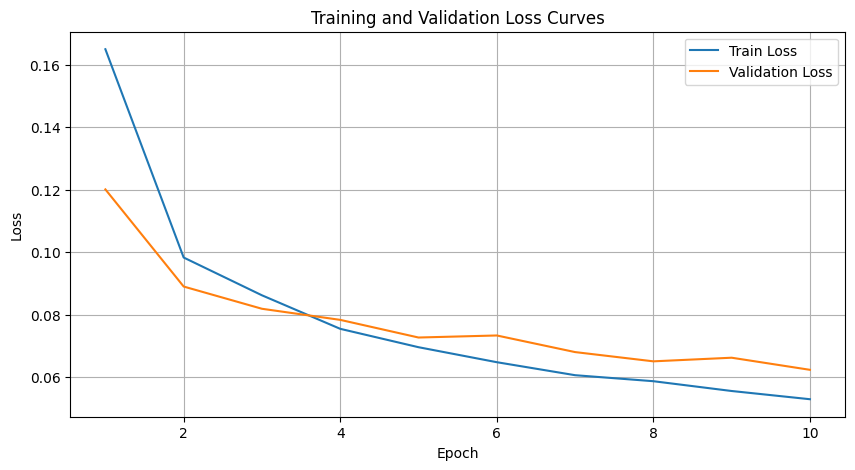

In [17]:
%%time

# Initialize the model
single_cnn = SingleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(single_cnn.parameters(), lr=0.001)

# Applying sugumented data for training single_cnn model
train(single_cnn, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=10,save_dir='./outputs/single_cnn_aug')


In [18]:
%%time

evaluate(single_cnn, test_loader, num_classes=5)

Accuracy: 97.69%
F1 Score: 0.9769
Precision: 0.9771
Recall: 0.9769

Confusion Matrix:
[[3928    0   68    2    2]
 [  16  965   19    0    0]
 [  89    1  909    0    1]
 [   1    0    0 2999    0]
 [  25    0    1    6  968]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      4000
     Class 1       1.00      0.96      0.98      1000
     Class 2       0.91      0.91      0.91      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       1.00      0.97      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.97      0.96      0.97     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 5.05 s, sys: 5.1 s, total: 10.2 s
Wall time: 1.47 s


### Inlcuding dropout

In [19]:
class SingleCNNWithDropout(nn.Module):
    def __init__(self):
        super(SingleCNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(in_features=32 * 12 * 12, out_features=100)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=100, out_features=len(label_mapping))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 32 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
%%time

# Initialize the model
single_cnn_with_dropout = SingleCNNWithDropout()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(single_cnn.parameters(), lr=0.001)

CPU times: user 3.9 ms, sys: 7.56 ms, total: 11.5 ms
Wall time: 2.58 ms


Epoch 1/10, Train Loss: 1.6099, Valid Loss: 1.6084
Saving best checkpoint to ./outputs/single_cnn_drop_aug/best_checkpoint.pth
Epoch 2/10, Train Loss: 1.6098, Valid Loss: 1.6085
Epoch 3/10, Train Loss: 1.6095, Valid Loss: 1.6082
Saving best checkpoint to ./outputs/single_cnn_drop_aug/best_checkpoint.pth
Epoch 4/10, Train Loss: 1.6097, Valid Loss: 1.6085
Epoch 5/10, Train Loss: 1.6097, Valid Loss: 1.6084
Epoch 6/10, Train Loss: 1.6098, Valid Loss: 1.6083
Epoch 7/10, Train Loss: 1.6098, Valid Loss: 1.6084
Epoch 8/10, Train Loss: 1.6097, Valid Loss: 1.6083
Epoch 9/10, Train Loss: 1.6097, Valid Loss: 1.6084
Epoch 10/10, Train Loss: 1.6096, Valid Loss: 1.6084
CPU times: user 13min 18s, sys: 18min 41s, total: 32min
Wall time: 4min 15s


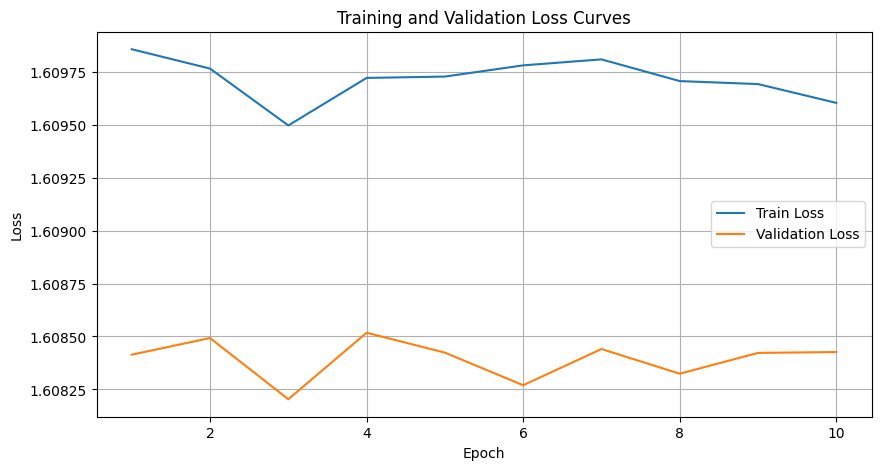

In [21]:
%%time

# Training single_cnn_with_dropout on augumented data
train(single_cnn_with_dropout, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=10,save_dir='./outputs/single_cnn_drop_aug')

No convergence reached. We can increase number of epochs to see if the model learns, however, considering that we are training on augumented data and using a simple network the above curve makes sense. On augumentation, we have increased the dataset size and also included variations of the image (new patterns), on top of this when we added dropout the single cnn network is struggling to learn especially classes 1,2 and 3. This can also be understood as some of these classes have less samples as we observed in class distribution analysis. Another explanation can be that these classes (bags, shoes have more complex partterns than upper part and bottom part)

### Treating class imbalance

In [22]:
%%time

# calculating class weights
num_classes = len(label_mapping)
class_sizes = np.zeros(num_classes, dtype=int)

for _, labels in train_loader:
    class_sizes += np.bincount(labels.numpy(), minlength=num_classes)

class_weights = [sum(class_sizes) / (num_classes * size) for size in class_sizes]
# Normalizing
class_weights_normalized = [round(weight / sum(class_weights),2) for weight in class_weights]

class_weights_normalized


CPU times: user 2.6 s, sys: 579 ms, total: 3.18 s
Wall time: 2.49 s


[0.07, 0.28, 0.28, 0.09, 0.28]

Epoch 1/20, Train Loss: 0.2102, Valid Loss: 0.1358
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 2/20, Train Loss: 0.1248, Valid Loss: 0.1177
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 3/20, Train Loss: 0.1035, Valid Loss: 0.1054
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 4/20, Train Loss: 0.0934, Valid Loss: 0.0977
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 5/20, Train Loss: 0.0851, Valid Loss: 0.0901
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 6/20, Train Loss: 0.0794, Valid Loss: 0.0823
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 7/20, Train Loss: 0.0724, Valid Loss: 0.0793
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 8/20, Train Loss: 0.0709, Valid Loss: 0.0773
Saving best checkpoint to ./outputs/single_cnn_cw/best_checkpoint.pth
Epoch 9/20, Train Loss: 0.0666, 

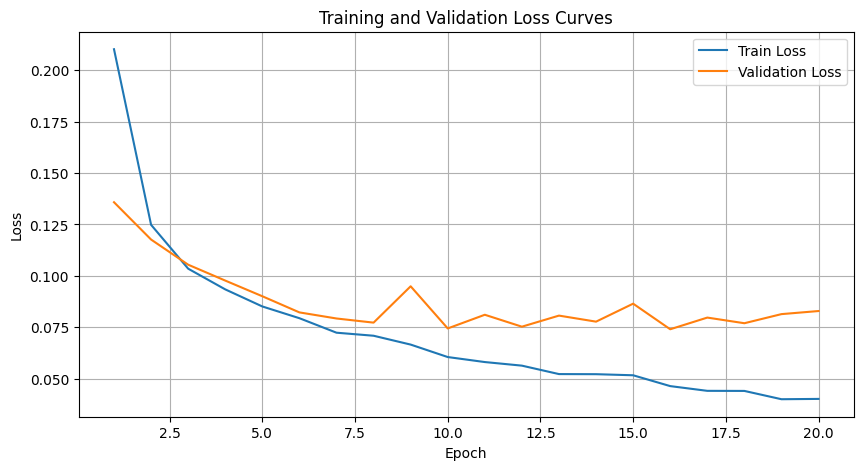

In [33]:
%%time

# Initialize the model
single_cnn_cw = SingleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights_normalized))
optimizer = optim.Adam(single_cnn_cw.parameters(), lr=0.001)

# Performing training on single cnn class weights model using augumented data
train(single_cnn_cw, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=20,save_dir='./outputs/single_cnn_cw')


In [34]:
%%time

evaluate(single_cnn_cw, test_loader, num_classes=5)

Accuracy: 97.68%
F1 Score: 0.9770
Precision: 0.9776
Recall: 0.9768

Confusion Matrix:
[[3851    9  121    2   17]
 [   3  989    7    0    1]
 [  46    7  943    1    3]
 [   1    0    0 2999    0]
 [   8    0    2    4  986]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.96      0.97      4000
     Class 1       0.98      0.99      0.99      1000
     Class 2       0.88      0.94      0.91      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.98      0.99      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.96      0.98      0.97     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 4.96 s, sys: 4.97 s, total: 9.93 s
Wall time: 1.45 s


### Normalization

In [40]:
%%time

data_path = '../data'

# Normalizing the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset_norm = datasets.FashionMNIST(root=data_path, train=True, transform=transform, download=True)
train_dataset_norm.targets = apply_custom_labels(train_dataset_norm.targets)

test_dataset_norm = datasets.FashionMNIST(root=data_path, train=False, transform=transform, download=True)
test_dataset_norm.targets = apply_custom_labels(test_dataset_norm.targets)

valid_size_norm = int(0.2 * len(train_dataset_norm)) 
train_size_norm = len(train_dataset_norm) - valid_size_norm

train_dataset_norm, valid_dataset_norm = random_split(train_dataset_norm, [train_size_norm, valid_size_norm])

batch_size = 64
train_loader_norm = DataLoader(train_dataset_norm, batch_size=batch_size, shuffle=True)
valid_loader_norm = DataLoader(valid_dataset_norm, batch_size=batch_size, shuffle=True)
test_loader_norm = DataLoader(test_dataset_norm, batch_size=batch_size, shuffle=True)


CPU times: user 1.61 s, sys: 760 ms, total: 2.37 s
Wall time: 1.63 s


Epoch 1/10, Train Loss: 0.1558, Valid Loss: 0.1066
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.0903, Valid Loss: 0.0932
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0699, Valid Loss: 0.0947
Epoch 4/10, Train Loss: 0.0572, Valid Loss: 0.0978
Epoch 5/10, Train Loss: 0.0431, Valid Loss: 0.0836
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0378, Valid Loss: 0.0771
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 7/10, Train Loss: 0.0314, Valid Loss: 0.0654
Saving best checkpoint to ./outputs/single_cnn_norm/best_checkpoint.pth
Epoch 8/10, Train Loss: 0.0274, Valid Loss: 0.0761
Epoch 9/10, Train Loss: 0.0240, Valid Loss: 0.0778
Epoch 10/10, Train Loss: 0.0212, Valid Loss: 0.1067
CPU times: user 9min 36s, sys: 9min 39s, total: 19min 16s
Wall time: 2min 34s


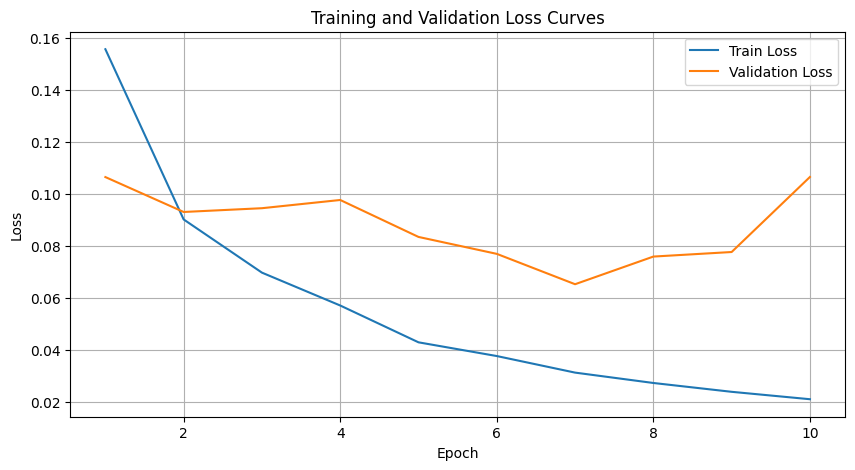

In [41]:
%%time

# Initialize the model
single_cnn_norm = SingleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights_normalized))
optimizer = optim.Adam(single_cnn_norm.parameters(), lr=0.001)

# Performing training on single cnn using normalized data
train(single_cnn_norm, train_loader_norm, valid_loader_norm, criterion, optimizer, num_epochs=10,save_dir='./outputs/single_cnn_norm')


In [42]:
evaluate(single_cnn_norm, test_loader_norm, num_classes=5)

Accuracy: 96.60%
F1 Score: 0.9671
Precision: 0.9707
Recall: 0.9660

Confusion Matrix:
[[3747    2  235    3   13]
 [   7  974   19    0    0]
 [  27    0  973    0    0]
 [   1    0    1 2998    0]
 [  16    2    8    6  968]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.94      0.96      4000
     Class 1       1.00      0.97      0.98      1000
     Class 2       0.79      0.97      0.87      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.99      0.97      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.95      0.97      0.96     10000
weighted avg       0.97      0.97      0.97     10000



## Double CNN model

In [35]:
class DoubleCNN(nn.Module):
    def __init__(self):
        super(DoubleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=len(label_mapping))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Epoch 1/10, Train Loss: 0.2112, Valid Loss: 0.1292
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.1103, Valid Loss: 0.1139
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0939, Valid Loss: 0.0936
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.0852, Valid Loss: 0.0863
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 5/10, Train Loss: 0.0775, Valid Loss: 0.0743
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0731, Valid Loss: 0.0736
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 7/10, Train Loss: 0.0678, Valid Loss: 0.0667
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 8/10, Train Loss: 0.0630, Valid Loss: 0.0674
Epoch 9/10, Train Loss: 0.0602, Valid Loss: 0.0657
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 10/10, Train Loss: 0.0546, Valid Loss: 0.0640
Saving best checkpoint to ./outputs/best_

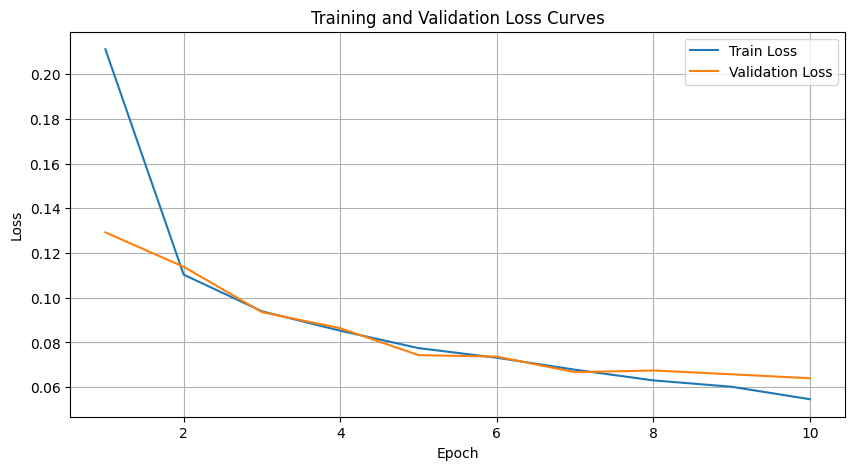

In [36]:
%%time

# Initialize the model
double_cnn = DoubleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(double_cnn.parameters(), lr=0.001)

# Training double cnn using augumented data
train(double_cnn, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=10,save_dir='./outputs/double_cnn')


The above graph showcases that the model is overfitting, looking at the plot, we can fix the number of epochs to be 3.

In [37]:
%%time

# Evaluate the baseline model
evaluate(double_cnn, test_loader, num_classes=5)


Accuracy: 97.70%
F1 Score: 0.9769
Precision: 0.9769
Recall: 0.9770

Confusion Matrix:
[[3923    2   58    1   16]
 [  15  973   10    0    2]
 [  97    3  899    0    1]
 [   2    0    0 2998    0]
 [  17    0    0    6  977]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      4000
     Class 1       0.99      0.97      0.98      1000
     Class 2       0.93      0.90      0.91      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.98      0.98      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: user 8.11 s, sys: 7.18 s, total: 15.3 s
Wall time: 2.4 s


Epoch 1/10, Train Loss: 0.2400, Valid Loss: 0.1658
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.1315, Valid Loss: 0.1284
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.1131, Valid Loss: 0.1268
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.1024, Valid Loss: 0.0985
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 5/10, Train Loss: 0.0960, Valid Loss: 0.0995
Epoch 6/10, Train Loss: 0.0867, Valid Loss: 0.0901
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 7/10, Train Loss: 0.0803, Valid Loss: 0.0879
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 8/10, Train Loss: 0.0741, Valid Loss: 0.0846
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 9/10, Train Loss: 0.0695, Valid Loss: 0.0788
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 10/10, Train Loss: 0.0680, Valid Loss: 0.0819
CPU times: user 20min 3s, sys: 19min 29s,

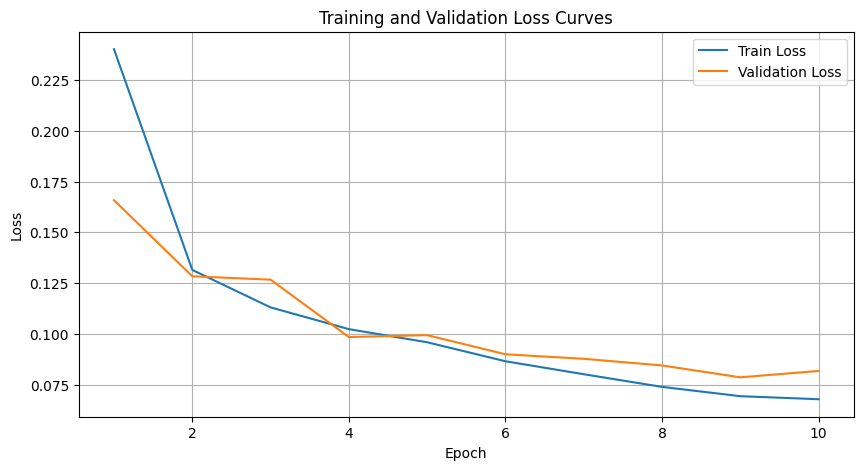

In [38]:
%%time

# Initialize the model
double_cnn_cw = DoubleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights_normalized))
optimizer = optim.Adam(double_cnn_cw.parameters(), lr=0.001)

# Training double cnn using augumented data and using class weights
train(double_cnn_cw, train_loader_aug, valid_loader_aug, criterion, optimizer, num_epochs=10,save_dir='./outputs/double_cnn_cw')


In [39]:
%%time

# Evaluate the baseline model
evaluate(double_cnn_cw, test_loader, num_classes=5)


Accuracy: 96.64%
F1 Score: 0.9675
Precision: 0.9713
Recall: 0.9664

Confusion Matrix:
[[3733    2  240    1   24]
 [   4  975   19    0    2]
 [  22    2  976    0    0]
 [   1    0    1 2997    1]
 [   8    0    3    6  983]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.93      0.96      4000
     Class 1       1.00      0.97      0.99      1000
     Class 2       0.79      0.98      0.87      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.97      0.98      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.95      0.97      0.96     10000
weighted avg       0.97      0.97      0.97     10000

CPU times: user 7.51 s, sys: 6.23 s, total: 13.7 s
Wall time: 1.98 s


### Other Experiments
This notebook only contains technique experiments like augumentation, normalization, dropout, class weights, using more complex model etc. However we havent experimented with hyper parameters like learning_rate, kernal size, padding etc.. apart from that we have fixed optimizer, activation function and loss function. We can derive further analysis and conclusions from the experiments performed so far to choose next phase of experiments.